# Delays
#### References: 
- Theory and Techniques of Electronic Music, Miller puckette: http://msp.ucsd.edu/techniques/v0.03/book.pdf
- Physical Audio Signal Processing, Julius O. Smith III: https://ccrma.stanford.edu/~jos/pasp/Delay_Lines.html

## Contents
 - shift operation
 - simple delay
 - command line program, batch processing
 - OOP (Object oriented programming)
 - schroeder allpass
 - Schroeder reverb

## Homework
Make a command line program that applies a tap-delay, so a delay with multiple delay taps, but only one buffer.
Alternatively: Implement another one of the reverbs described in schroeders paper, also as a command line program.


In [1]:
%pylab
%matplotlib inline
import scipy.signal as sig
import librosa
import IPython

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


## Test Signal: Unit Impulse, $\delta(n)$

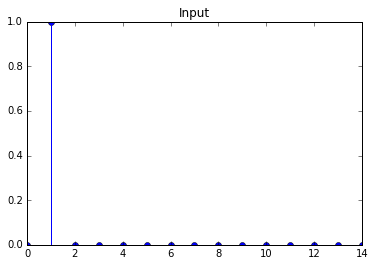

In [2]:
N = 15
n = arange(N)
inputSig = sig.unit_impulse(N, idx=1)
stem(inputSig)
title('Input')
show()


## Most Simplistic delay
Prepending zeros (and omitting tail).
The most simple delay just shifts its input signal $x$ a given number, $m$, of samples to produce output signal $y$.

### Difference Equation:
$$y(n) = x(n-m)$$

### The transfer Fuction:
$$H(z)=z^{-m}$$


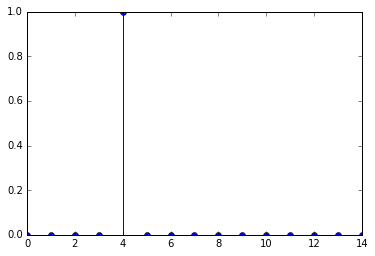

In [3]:
m = 3 #delay in samples
zerosPrepended = insert(inputSig,0,zeros(m))
tailRemoved = zerosPrepended[0:-m]
stem(tailRemoved)
show()

## A Delay that allows for Feedback
### Diff Eq:
$y(n) = x(n)+a\cdot y(n-m)$

### Transfer Function
$H(z) = \frac{1}{1-a\cdot z^{-m}}$


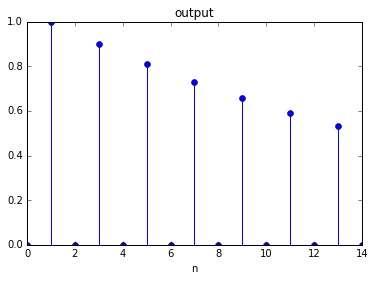

In [4]:
maxDelLength = 10
delayBuffer = zeros(maxDelLength)
y = 0
opSig = zeros(N)
delaySamps = 2
for ni in n:
    xn = inputSig[ni]     
    opSig[ni] = delayBuffer[(ni-delaySamps)%maxDelLength]*0.9+xn
    delayBuffer[ni%maxDelLength] = opSig[ni]
stem(opSig)
title('output')
xlabel('n')
show()

# Fractional Delay

## Linear Interpolation

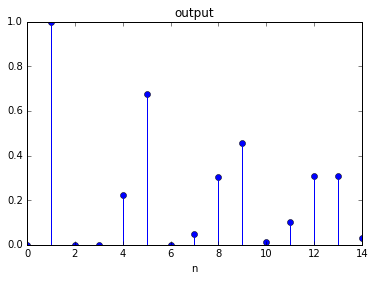

In [5]:
maxDelLength = 10
delayBuffer = zeros(maxDelLength)
y = 0
opSig = zeros(N)
delaySamps = 3.75
for ni in n:
    xn = inputSig[ni]
    indLow = int(floor(delaySamps))
    indHigh = int(ceil(delaySamps))
    fraction = delaySamps-indLow
    fractionRes = 1.-fraction
    delayOut = (fractionRes*(delayBuffer[(ni-indLow)%maxDelLength])+fraction*(delayBuffer[(ni-indHigh)%maxDelLength]))
    opSig[ni] = delayOut *0.9+xn
    delayBuffer[ni%maxDelLength] = opSig[ni]
stem(opSig)
title('output')
xlabel('n')
show()

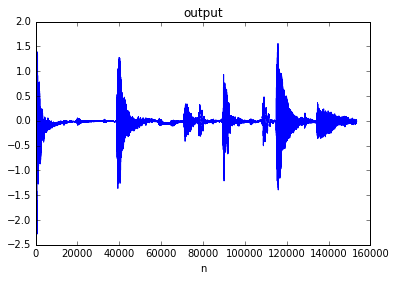

In [6]:
p = '/root/Documents/MATLAB/data/drumLoop.wav'
x,sr = librosa.load(p,mono=True, sr=44100)

N = len(x)
n = arange(N)
inputSig = x
maxDelLength = 30
delayBuffer = zeros(maxDelLength)
y = 0
opSig = zeros(N)
delaySamps = 28.75
for ni in n:
    xn = inputSig[ni]
    indLow = int(floor(delaySamps))
    indHigh = int(ceil(delaySamps))
    fraction = delaySamps-indLow
    fractionRes = 1.-fraction
    delayOut = (fractionRes*(delayBuffer[(ni-indLow)%maxDelLength])+fraction*(delayBuffer[(ni-indHigh)%maxDelLength]))
    opSig[ni] = delayOut *0.99+xn
    delayBuffer[ni%maxDelLength] = opSig[ni]
plot(opSig)
title('output')
xlabel('n')
show()

In [7]:
p = '/tmp/tmpFile.wav'
librosa.output.write_wav(p,opSig,sr,norm=True)

In [8]:
IPython.display.Audio(p)

In [9]:
p = 'drumLoop.wav'

In [10]:
IPython.display.Audio(p)

In [11]:
x,sr = librosa.load(p,mono=True, sr=44100)

## Object Oriented Programming, a delay class

In [12]:
class SimpleDelay():
    def __init__(self, maxLenSamples, currentDelay):
        
        self.delayBuffer = zeros(maxLenSamples +1 )
        self.maxLenSamples = maxLenSamples + 1
        self.currentDelay = currentDelay
        self.writePos = 0
        self.readPos = (self.writePos+self.currentDelay)%self.maxLenSamples
        return
    def step(self,x):
        self.delayBuffer[self.writePos] = x
        y = self.delayBuffer[(self.writePos-self.currentDelay)%self.maxLenSamples]
        self.readPos= (self.readPos+1)%self.maxLenSamples
        self.writePos= (self.writePos+1)%self.maxLenSamples
        return y

### Using the class

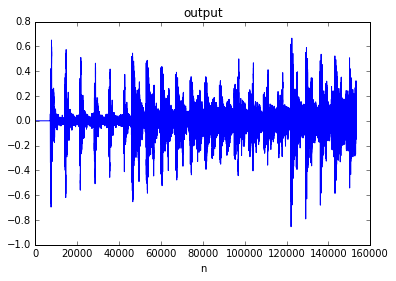

In [13]:
p = 'drumLoop.wav'
x,sr = librosa.load(p,mono=True, sr=44100)

N = len(x)
n = arange(N)
inputSig = x
dela = SimpleDelay(10000,7000)
y = 0
opSig = zeros(N)
delaySamps = 28
for ni in n:
    xn = inputSig[ni]
    delIn = y*0.9 +xn
    y = dela.step(delIn)
    opSig[ni] = y
plot(opSig)
title('output')
xlabel('n')
show()

# Schroeder Allpass

https://ccrma.stanford.edu/~jos/pasp/Allpass_Two_Combs.html


![schroeder allpass](img/img596.png)


$\begin{eqnarray*}
v(n) &=& x(n) - a_M v(n-M)\\
y(n) &=& b_0 v(n) + v(n-M).
\end{eqnarray*}$

which can be reordered to:

$ y(n) = b_0 x(n) + x(n-M) - a_M y(n-M)$

Transfer function:

$\displaystyle H(z) = \frac{b_0 + z^{-M}}{1 + a_M z^{-M}}$

The Schroeder Allpass is a special case of the more general Feedback-Feedforward Combfilter above, in which $b_0 = a_M$.
So we define the more general Case first, make a class, and use *inheritance* for the special case, the schroeder allpass.


In [14]:
class CombFilter():
    def __init__(self, delMax,delCurrent):
        self.delout=0
        self.zm = SimpleDelay(delMax,delCurrent)
        return
    
    def step(self,x,am,b0):
        vn = x+(-am*self.delout)
        y = self.delout+vn*b0
        self.delout = self.zm.step(vn)
        return y

    def process(self,x,am,b0):
        y = zeros_like(x)
        for i in range(len(x)):
            y[i]=self.step(x[i],am,b0)
        return y

In [15]:
class SchroederAllpass(CombFilter):
    def step(self,x,am):
        return CombFilter.step(self,x,am,am)

    def process(self,x,am):
        y = zeros_like(x)
        for i in range(len(x)):
            y[i]=self.step(x[i],am)
        return y    

In [16]:
ap2 = SchroederAllpass(44000,4000)
y = zeros_like(x)
am = 0.9
for i in range(N):
    y[i]=ap2.step(x[i],am)
    

In [17]:
times = random.random(20)*1000
y = x
am = 0.7
for tim in times:
    thisAp = SchroederAllpass(int(tim),int(tim))
    y = thisAp.process(y,am)


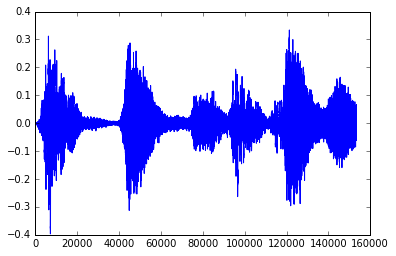

In [18]:
plot(y)

In [19]:
IPython.display.Audio(data=y,rate=sr)

# Schroeder Reverb
https://ccrma.stanford.edu/~jos/pasp/Schroeder_Reverberators.html

![schroeder](img/schroeder.png)

In [20]:
def allPassSeries(x,times,am):
    y = x
    for tim in times:
        thisAp = SchroederAllpass(int(tim),int(tim))
        y = thisAp.process(y,am)
    return y

In [21]:
def parallelDelays(x,times, am, b0):
    y = zeros_like(x)
    for tim in times:
        thisDel = CombFilter(int(tim),int(tim))
        y = y+thisDel.process(x,am,b0)
    return y

In [22]:
x = insert(x,len(x),zeros(sr*5))

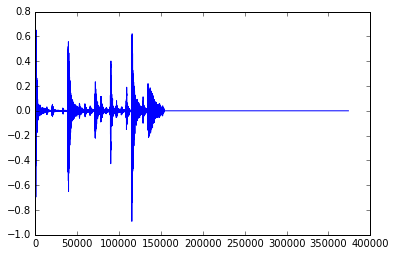

In [23]:
plot(x)

In [24]:
times = random.random(10)*300*sr/1000
serOut = allPassSeries(x,times,0.7)
times = random.random(7)*2000*sr/1000
parOut = parallelDelays(serOut,times, 0.99,0.1)

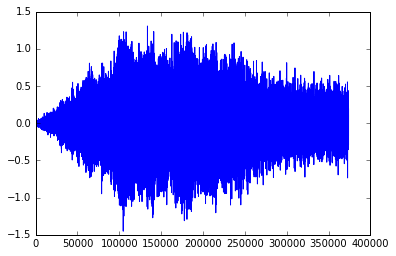

In [25]:
plot(parOut)

In [26]:
IPython.display.Audio(data=parOut,rate=sr)

## Allpass ≠ Allpass
Being 'allpass' is a trait, a feature of a system. There isn't really *the* allpass filter. Below, we construct an allpass filter by adding two filters together, a highpass and a lowpass. This is done frequently in filterbanks for correct phase-alignment. The one below doesnt diffuse the signal so mus but introduces a more delay to low frequencies than to high frequencies, resulting in dispersion-like effects. 

In [27]:
class allpass():
    def __init__(self, freq, order,sr):
        self.freq = freq
        self.sr= sr
        self.order = order
        
        self.Wn = self.freq/(self.sr/2)
#         print(self.Wn)
        self.constructFilter()
#         print(self.lpSos)
        return
    def constructFilter(self):
        self.lpSos = sig.butter(self.order,self.Wn,output='sos',btype='lowpass')
        self.hpSos = sig.butter(self.order,self.Wn,output='sos',btype='highpass')
#         self.lp = fi.Filter(self.lpSos)
#         self.hp = fi.Filter(self.hpSos)
#         print(self.lpSos)
    def filt(self,x):
        y1 = sig.sosfilt(self.lpSos,x)
        y2 = sig.sosfilt(self.hpSos,x)
        y = y2+y1
        return y
        
        

In [28]:
freqs = random.random(50)*10
# print(freqs)
y = x
for fr in freqs:
    ap = allpass(fr,5,sr)
    y = ap.filt(y)

In [37]:
IPython.display.Audio(data=y,rate=sr)

In [30]:
print('bla')

bla


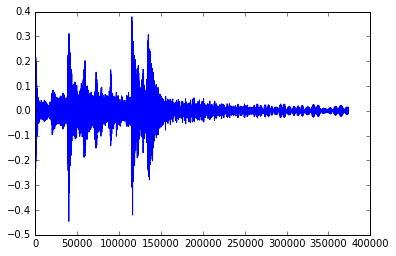

In [31]:
plot(y)

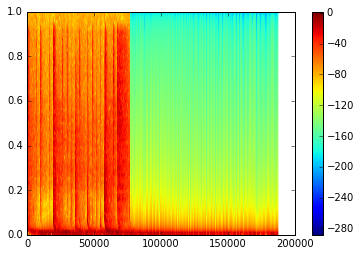

In [32]:
specgram(y)
colorbar()
show()

In [34]:
# specgram(Fc=)

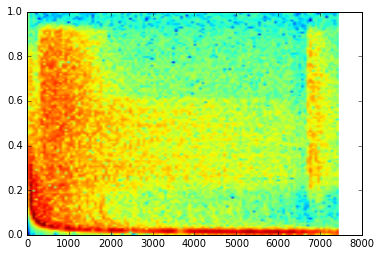

In [35]:
specgram(y[0:15000])
show()

In [ ]:
print('bla')